# Fit Model Parameters to Data #
### Nitika Yadlapalli ###
Use existing all sky maps published on LAMBDA (https://lambda.gsfc.nasa.gov/) to find model parameters that best fit the data

Currently, MCMC models based on example shown here: https://emcee.readthedocs.io/en/v2.2.1/user/line/

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import emcee
from scipy import stats
import corner
from const import *

import ModelDefinitions as MD
import LogProb as LP
import importlib
importlib.reload(LP)
importlib.reload(MD)

<module 'ModelDefinitions' from '/home/nitikayad96/Research/Radio_Background/radio-background/ModelDefinitions.py'>

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1176: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1177: RuntimeWarning: invalid value encountered

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


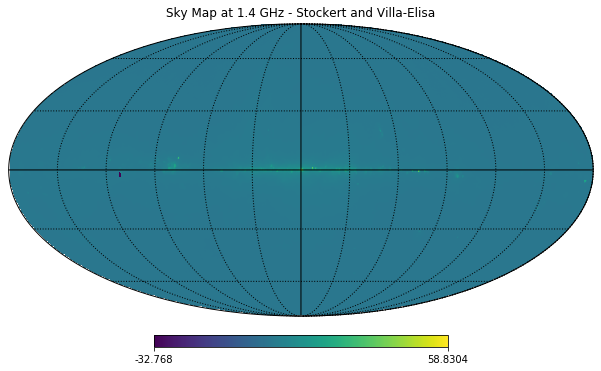

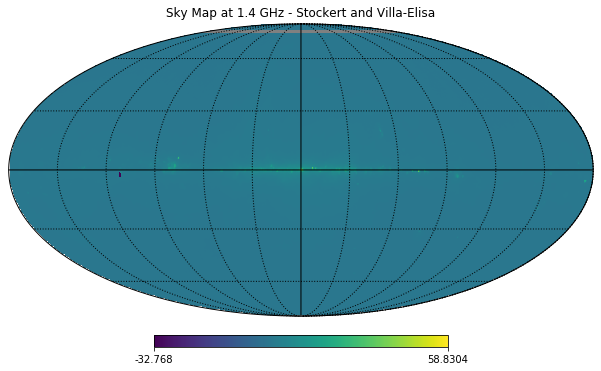

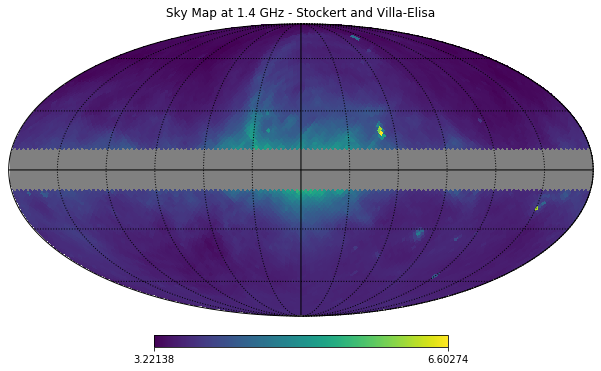

In [6]:
## show 1.4 GHz sky map ##

map_1420 = hp.read_map('STOCKERT+VILLA-EwLISA_1420MHz_1_256.fits')
map_1420_mod = hp.read_map('STOCKERT+VILLA-ELISA_1420MHz_1_256.fits')
map_1420_dg = hp.pixelfunc.ud_grade(map_1420, 32)

#Mask all pixels between -10 < b < +10 by setting them all to zero
map_1420_mod[idx_exb] = None

idx_dg = hp.query_strip(NSIDE_dg, np.deg2rad(90-b_mask), np.deg2rad(90+b_mask))
map_1420_dg[idx_exb] = None

hp.mollview(map_1420/1000, title = "Sky Map at 1.4 GHz - Stockert and Villa-Elisa")
hp.graticule()

hp.mollview(map_1420_mod/1000, title = "Sky Map at 1.4 GHz - Stockert and Villa-Elisa")
hp.graticule()

hp.mollview(map_1420_dg/1000, title = "Sky Map at 1.4 GHz - Stockert and Villa-Elisa")
hp.graticule()

## 1.4 GHz Map with Disk + Bkg Model ##
Sky map used: https://lambda.gsfc.nasa.gov/product/foreground/fg_stockert_villa_info.cfm

Assume only disk + T_bkg

In [7]:
samples = np.load("disk+bkg.npz")['samples']
samples = samples[:,10:,:]
print(samples.shape)

ndim=4
samples_reshape = samples.reshape((-1, ndim))


samples_reshape[:,0] = np.log10(samples_reshape[:,0])
samples_reshape[:,1] = np.log10(samples_reshape[:,1])
samples_reshape[:,2] = np.log10(samples_reshape[:,2])

(200, 990, 4)


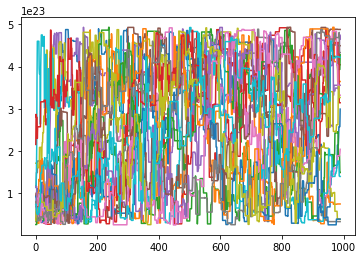

In [25]:
plt.figure()
for i in range(20):
    plt.plot(samples[i,:,0])

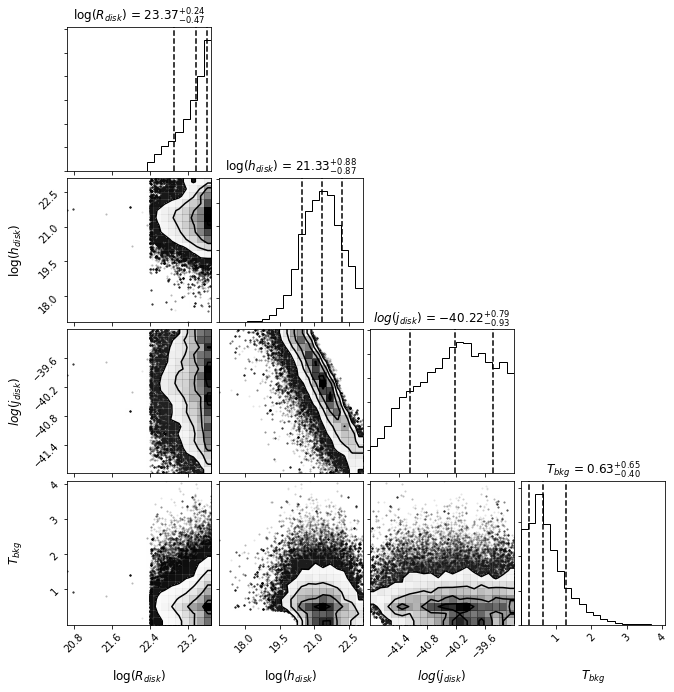

In [26]:
fig = corner.corner(samples_reshape, labels=["log($R_{disk})$","log($h_{disk})$","$log(j_{disk})$", "$T_{bkg}$"],
                    label_kwargs={"fontsize": 12}, show_titles=True, title_kwargs={"fontsize": 12},
                    quantiles=[0.16,0.5,0.84])

plt.savefig("notes/corner_disk+bkg.jpg")

-0.5248639657818338


Text(0.5, 1.0, 'Residuals for Disk+Background Model')

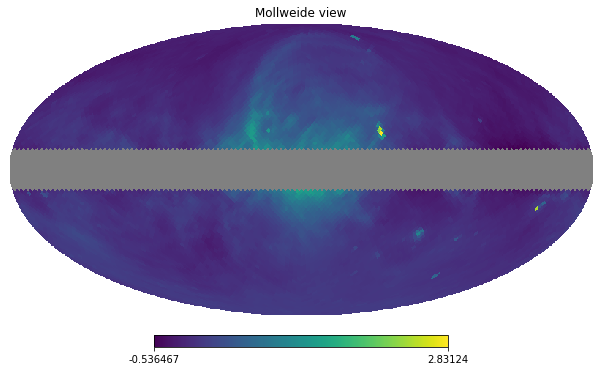

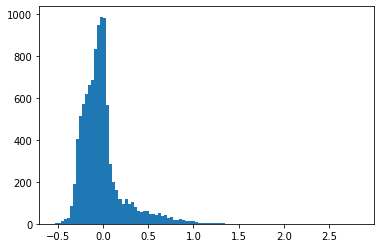

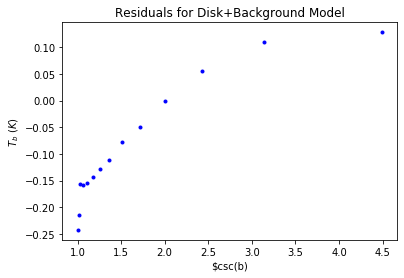

In [14]:
R_disk = 10**np.percentile(samples_reshape[:,0], 50)
h_disk = 10**np.percentile(samples_reshape[:,1], 50)
j_disk = 10**np.percentile(samples_reshape[:,2], 50)
T_bkg = np.percentile(samples_reshape[:,3], 50)

residuals = (map_1420_dg/1000 - T_bkg - T_eg - T_CMB) - (MD.LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk)*(c**2)/(2*k*(nu**2))
residuals2 = np.array([residuals[i] for i in range(len(residuals)) if i not in idx_exb])

hp.mollview(residuals)

plt.figure()
plt.hist(residuals2, bins=100)

print(LP.diskbkg([R_disk, h_disk, j_disk, T_bkg], nu, l, b, map_1420_dg/1000))

cscb, Tb_mean = MD.cscbplot(residuals, NSIDE_dg)

plt.figure()
plt.plot(cscb, Tb_mean, 'b.')
plt.ylabel('$T_{b}\ (K)$')
plt.xlabel('$csc(b)')
plt.title('Residuals for Disk+Background Model')

## 1.4 GHz Map with Halo + Bkg Model ##
Sky map used: https://lambda.gsfc.nasa.gov/product/foreground/fg_stockert_villa_info.cfm

Assume halo + bkg model

In [35]:
samples = np.load("halo+bkg.npz")['samples']
samples = samples[:,200:,:]
print(samples.shape)

ndim=3
samples_reshape = samples.reshape((-1, ndim))


samples_reshape[:,0] = np.log10(samples_reshape[:,0])
samples_reshape[:,1] = np.log10(samples_reshape[:,1])

(200, 800, 3)


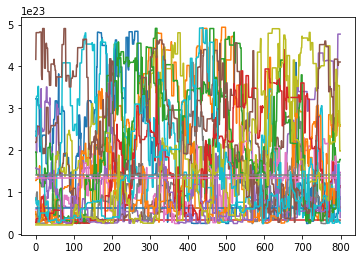

In [36]:
plt.figure()
for i in range(20):
    plt.plot(samples[i,:,0])

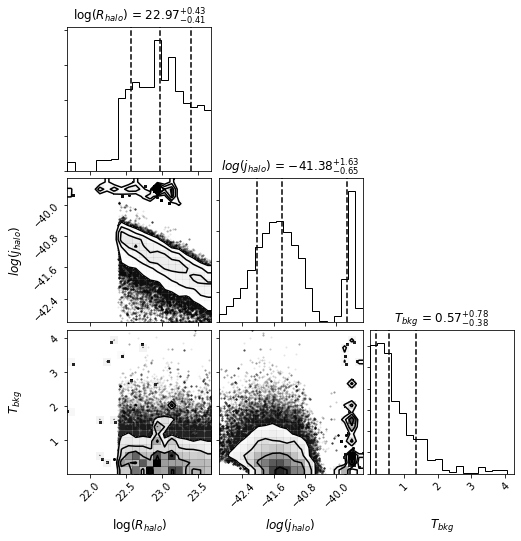

In [37]:
fig = corner.corner(samples_reshape, labels=["log($R_{halo})$","$log(j_{halo})$", "$T_{bkg}$"],
                    label_kwargs={"fontsize": 12}, show_titles=True, title_kwargs={"fontsize": 12},
                    quantiles=[0.16,0.5,0.84])

plt.savefig("notes/halo+bkg.jpg")

-0.8256391781008956


/home/nitikayad96/Research/Radio_Background/radio-background/LogProb.py:50: RuntimeWarning: invalid value encountered in less_equal
  neg_res_idx = np.argwhere(residuals<=0)


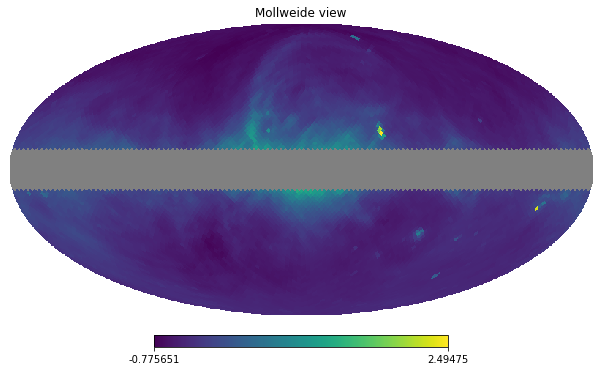

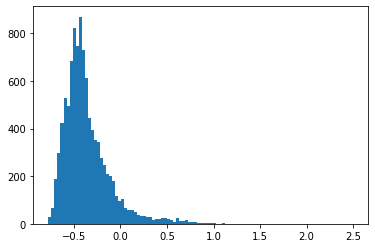

In [38]:
R_halo = 10**np.percentile(samples_reshape[:,0], 50)
j_halo = 10**np.percentile(samples_reshape[:,1], 50)
T_bkg = np.percentile(samples_reshape[:,2], 50)

residuals = (map_1420_dg/1000 - T_bkg - T_eg - T_CMB) - (MD.LineOfSightHalo(l, b, d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))
residuals2 = np.array([residuals[i] for i in range(len(residuals)) if i not in idx_exb])

hp.mollview(residuals)

plt.figure()
plt.hist(residuals2, bins=100)

print(LP.halobkg([R_halo, j_halo, T_bkg], nu, l, b, map_1420_dg/1000))


## 1.4 GHz Map with Disk+Halo+Uniform Background ##
Sky map used: https://lambda.gsfc.nasa.gov/product/foreground/fg_stockert_villa_info.cfm

Assume disk+halo+eg

In [6]:
samples = np.load("disk+halo+bkg.npz")['samples']
samples = samples[:,200:,:]
print(samples.shape)

ndim=6
samples_reshape = samples.reshape((-1, ndim))


samples_reshape[:,0] = np.log10(samples_reshape[:,0])
samples_reshape[:,1] = np.log10(samples_reshape[:,1])
samples_reshape[:,2] = np.log10(samples_reshape[:,2])
samples_reshape[:,3] = np.log10(samples_reshape[:,3])
samples_reshape[:,4] = np.log10(samples_reshape[:,4])


(400, 800, 6)


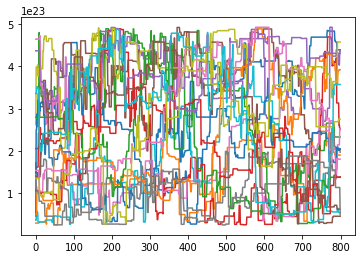

In [7]:
plt.figure()
for i in range(20):
    plt.plot(samples[i,:,0])

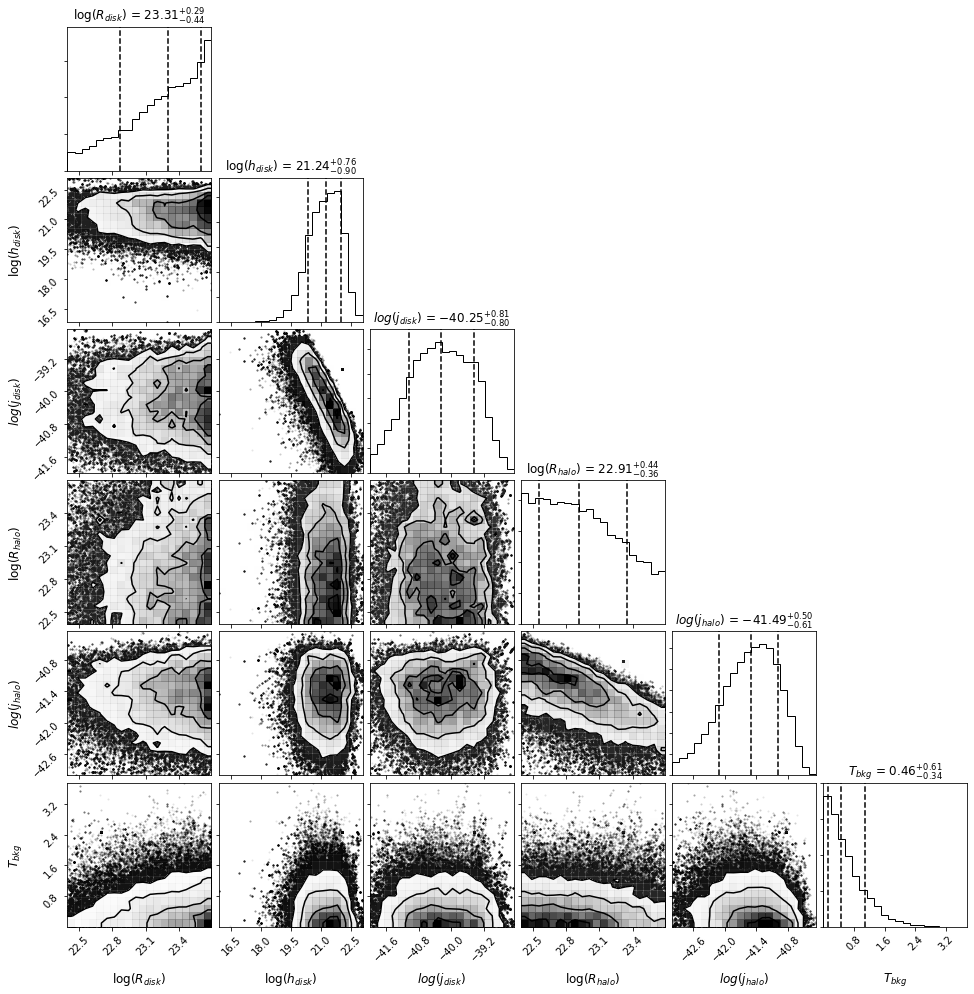

In [8]:
fig = corner.corner(samples_reshape, labels=["log($R_{disk})$","log($h_{disk})$","$log(j_{disk})$","log($R_{halo})$","$log(j_{halo})$", "$T_{bkg}$"],
                    label_kwargs={"fontsize": 12}, show_titles=True, title_kwargs={"fontsize": 12},
                    quantiles=[0.16,0.5,0.84])

#plt.savefig("notes/disk+bkg.jpg")

/home/nitikayad96/Research/Radio_Background/radio-background/ModelDefinitions.py:27: RuntimeWarning: invalid value encountered in true_divide
  b_above = np.nan_to_num((b > b_crit)*0.5*h_disk/(np.sin(b)))
/home/nitikayad96/Research/Radio_Background/radio-background/LogProb.py:108: RuntimeWarning: invalid value encountered in less_equal
  neg_res_idx = np.argwhere(residuals<=0)


-0.56877552800898


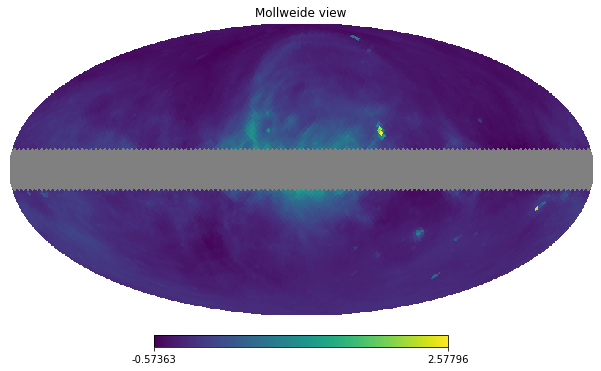

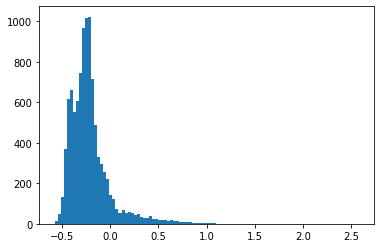

In [9]:
R_disk = 10**np.percentile(samples_reshape[:,0], 50)
h_disk = 10**np.percentile(samples_reshape[:,1], 50)
j_disk = 10**np.percentile(samples_reshape[:,2], 50)
R_halo = 10**np.percentile(samples_reshape[:,3], 50)
j_halo = 10**np.percentile(samples_reshape[:,4], 50)
T_bkg = np.percentile(samples_reshape[:,5], 50)

residuals = (map_1420_dg/1000 - T_bkg - T_eg - T_CMB) - (MD.LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk + MD.LineOfSightHalo(l, b, d, R_halo)*j_halo)*(c**2)/(2*k*(nu**2))
residuals2 = np.array([residuals[i] for i in range(len(residuals)) if i not in idx_exb])

hp.mollview(residuals)

plt.figure()
plt.hist(residuals2, bins=100)

print(LP.diskhalobkg([R_disk, h_disk, j_disk, R_halo, j_halo, T_bkg], nu, l, b, map_1420_dg/1000))


## 1.4 GHz Map with Disk+Halo##
Sky map used: https://lambda.gsfc.nasa.gov/product/foreground/fg_stockert_villa_info.cfm

Assume disk+halo

In [3]:
samples = np.load("disk+halo.npz")['samples']
#samples = samples[:,200:,:]
print(samples.shape)

ndim=5
samples_reshape = samples.reshape((-1, ndim))


samples_reshape[:,0] = np.log10(samples_reshape[:,0])
samples_reshape[:,1] = np.log10(samples_reshape[:,1])
samples_reshape[:,2] = np.log10(samples_reshape[:,2])
samples_reshape[:,3] = np.log10(samples_reshape[:,3])
samples_reshape[:,4] = np.log10(samples_reshape[:,4])


(200, 1000, 5)


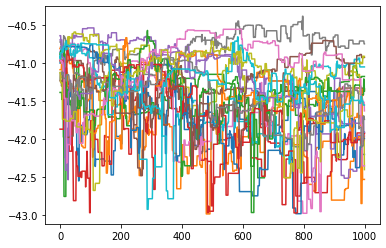

In [16]:
plt.figure()
for i in range(20):
    plt.plot(samples[i,:,4])

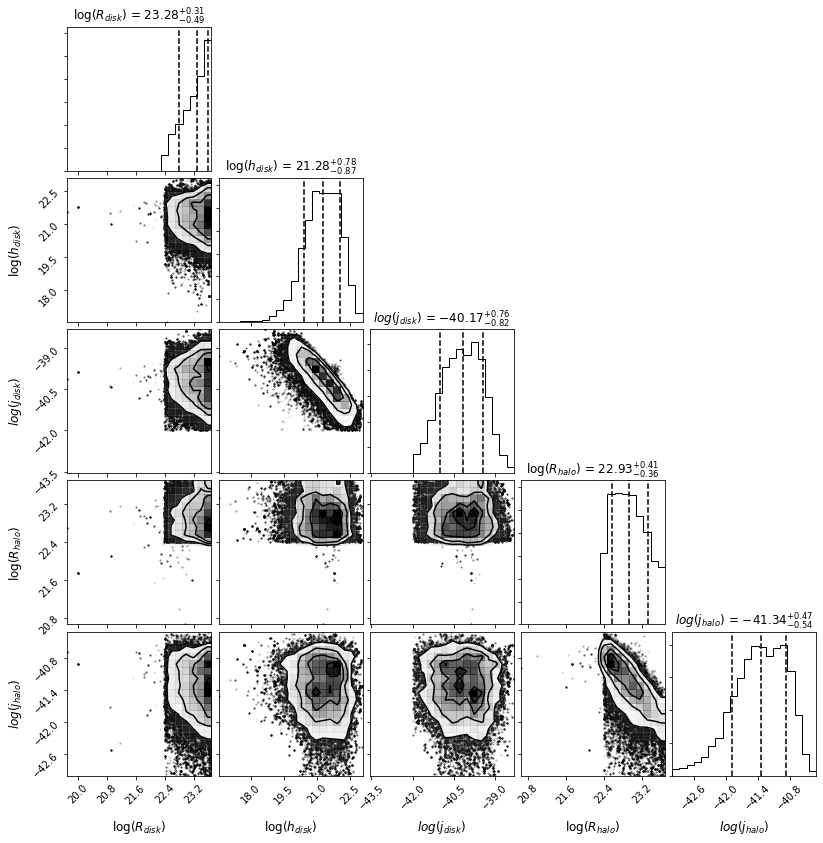

In [4]:
fig = corner.corner(samples_reshape, labels=["log($R_{disk})$","log($h_{disk})$","$log(j_{disk})$","log($R_{halo})$","$log(j_{halo})$"],
                    label_kwargs={"fontsize": 12}, show_titles=True, title_kwargs={"fontsize": 12},
                    quantiles=[0.16,0.5,0.84])

plt.savefig("notes/corner_disk+halo.jpg")